Author: Naveen Lalwani

#QUANTIZATION<BR>
The following python notebook demonstrates quantization of LeNet-300-100 model on MNIST dataset. The full trained and quantized models are saved as tflite models and inferences are checked on the MNIST test images.  

In [273]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.contrib import lite

Importing the <B>MNIST</B> dataset from the Tensorflow examples. The images get saved in the folder named "MNIST_data" until otherwise specifed.

In [274]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
testData, testLabels = mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


The total number of training examples in MNIST dataset is 55,000 has a total of 10 labels. Loading the training data.

In [275]:
numTrain = mnist.train.images.shape[0]
trainingData = mnist.train.images[:numTrain,:]
trainingLabels = mnist.train.labels[:numTrain,:]
print("Number of training examples = ", numTrain)
print("Training Data shape = ", trainingData.shape)
print("Training Data labels shape = ", trainingLabels.shape)

Number of training examples =  55000
Training Data shape =  (55000, 784)
Training Data labels shape =  (55000, 10)


The total number of training examples in MNIST dataset is 10,000 has a total of 10 labels. Loading the test data. Each example is a 28x28 pixel image flattened in an array with 784 values representing each pixel’s intensity. 

In [276]:
numTest = mnist.test.images.shape[0]
testData = mnist.test.images[:numTest,:]
testLabels = mnist.test.labels[:numTest,:]
print("Number of test examples = ", numTest)
print("Test Data shape = ", testData.shape)
print("Test Data labels shape = ", testLabels.shape)

Number of test examples =  10000
Test Data shape =  (10000, 784)
Test Data labels shape =  (10000, 10)


###Displaying the data from the MNIST dataset.

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


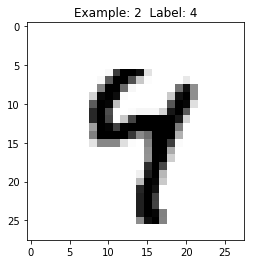

In [277]:
def display_digit(num):
    print(trainingLabels[num])
    label = trainingLabels[num].argmax(axis=0)
    image = trainingData[num].reshape([28,28])
    plt.title('Example: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
display_digit(2)

#Beginning the building of LeNet-300-100 neural network.

##Defining the training parameters.

In [278]:
learning_rate = 0.01
epochs = 4000
batch_size = 256
display_step = 500

##Network Parameters.

In [279]:
n_input = 784
n_classes = 10

##Use of Placeholders 
<list>
<li>Placeholder variables used to feed input into the graph.
<li>Model variables that are going to be optimized so as to make the model perform better.
<li>The model which is essentially just a mathematical function that calculates some output given the input in the placeholder variables and the model variables.
<li>A cost measure that can be used to guide the optimization of the variables.
<li>An optimization method which updates the variables of the model.
</list>
Placeholder variables serve as the input to the graph that we may change each time we execute the graph. We call this feeding the placeholder variables.<BR>
###Placeholder for input images <BR>
This will allow us to change the images that are input to the Tensorflow graph. TThe data type is set to float32 and the shape is set to [None, n_input], where None means that the tensor may hold an arbitrary number of images with each image being a vector of length "n_input". <BR>
###Placeholder for Labels <BR>
This will allow us to change the labesl that are true labels with the images in the placeholder X.  

In [280]:
# Placeholders
X = tf.placeholder(tf.float32, shape = [None, n_input], name = "X") # Placeholder for Images
Y = tf.placeholder(tf.float32, shape = [None, n_classes], name = "Y") # Placeholder for Labels

#Defining variables to be optimized 

The variables that are first optimized are weights and is defined as TensorFlow variable that is initialized randomly and whose shape is [n_input, n_classes], so it is a 2 dimensional tensor(matrix) with 784 rows and 10 columns.<BR>
##Defining weights & biases for the three layers.

In [281]:
weights = {
    # Fully Connected Layer 1: 784 input channels, 300 output channels
    'w1' : tf.Variable(tf.random_normal([784, 300]), name = 'w1'),
    # Fully Connected Layer 2: 300 input channels, 100 output channels
    'w2' : tf.Variable(tf.random_normal([300, 100]), name = 'w2'),
    # Fully Connected Layer 3: 100 input channels, 10 (number of classes) output channels
    'w3' : tf.Variable(tf.random_normal([100, 10]), name = 'w3')
}

In [282]:
biases = {
    'b1' : tf.Variable(tf.random_normal([300]), name = 'b1'),
    'b2' : tf.Variable(tf.random_normal([100]), name = 'b2'),
    'b3' : tf.Variable(tf.random_normal([10]), name = 'b3')
}

# DEFINING THE LENET-300-100 MODEL

In [283]:
def lenet_300_100(x, weight, bias):
    b_min1 = tf.reduce_min(bias['b1'])
    b_max1 = tf.reduce_max(bias['b1'])
    b_fake_quant1 = tf.fake_quant_with_min_max_vars(bias['b1'], 
                    min=b_min1, 
                    max=b_max1, 
                    narrow_range=True, 
                    name="b_weights1")
    
    
    b_min2 = tf.reduce_min(bias['b2'])
    b_max2 = tf.reduce_max(bias['b2'])
    b_fake_quant2 = tf.fake_quant_with_min_max_vars(bias['b2'], 
                    min=b_min2, 
                    max=b_max2, 
                    narrow_range=True,
                    name="b_weights2")
    
    
    b_min3 = tf.reduce_min(bias['b3'])
    b_max3 = tf.reduce_max(bias['b3'])
    b_fake_quant3 = tf.fake_quant_with_min_max_vars(bias['b3'], 
                    min=b_min3, 
                    max=b_max3, 
                    narrow_range=True,
                    name="b_weights3")
    
    # Fully Connected Layer 1
    # First multiply the weights with inputs, then add the bias, then apply RELU activation
    w_min1 = tf.reduce_min(weight['w1'])
    w_max1 = tf.reduce_max(weight['w1'])
    w_fake_quant1 = tf.fake_quant_with_min_max_vars(weight['w1'], 
                    min=w_min1, 
                    max=w_max1, 
                    narrow_range=True, 
                    name="quant_weights1")
    fc1 = tf.add(tf.matmul(x, w_fake_quant1), b_fake_quant1) # Linear Function
    fc1 = tf.nn.relu(fc1) # Activation Function
    fc1_fake_quant1 = tf.fake_quant_with_min_max_vars(fc1, 
                    min=-500.0, 
                    max=500.0, 
                    narrow_range=False,
                    name="act_weights1")
    
    w_min2 = tf.reduce_min(weight['w2'])
    w_max2 = tf.reduce_max(weight['w2'])
    w_fake_quant2 = tf.fake_quant_with_min_max_vars(weight['w2'], 
                    min=w_min2, 
                    max=w_max2, 
                    narrow_range=True, # will be explained below
                    name="quant_weights2")
    
    # Fully Connected Layer 2
    fc2 = tf.add(tf.matmul(fc1_fake_quant1, w_fake_quant2), b_fake_quant2) # Linear Function
    fc2 = tf.nn.relu(fc2) # Activation Function
    fc2_fake_quant = tf.fake_quant_with_min_max_vars(fc2, 
                    min=-500.0, 
                    max=500.0, 
                    narrow_range=False,
                    name="act_weights2")
    
    w_min3 = tf.reduce_min(weight['w3'])
    w_max3 = tf.reduce_max(weight['w3'])
    w_fake_quant3 = tf.fake_quant_with_min_max_vars(weight['w3'], 
                    min=w_min3, 
                    max=w_max3, 
                    narrow_range=True,
                    name="quant_weights3")
    # Ouput Layer
    out = tf.add(tf.matmul(fc2_fake_quant, w_fake_quant3), b_fake_quant3) # Output Layer
    
    return out

#Training the model <BR>
<B>Logits</B> is interpreted to be the unnormalised (or not-yet normalised) predictions (or outputs) of a model. These can give results, but we don't normally stop with logits, because interpreting their raw values is not easy.

In [284]:
# Get probabilities for the input for all the classes
logits = lenet_300_100(X, weights, biases)

##Cross Entropy Loss 
Compute the cross entropy loss for the model for all classes. Cross Entropy is a continuous function that is always positive and if the predicted output of the model exactly 
 matches the desired output then the cross entropy loss equals zero. The goal of the optimization is therefore to minimize the cross-entropy loss so it gets as close to zero 
 as possible by changing the weights and biases of the model.

In [285]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = Y)

We have calculated the cross-entropy for each of the image classifications so we have a measure of how well the model performs on each image individually but in order to use 
the cross-entropy to guide the optimization of the model;s variables we need a single scalar value, so we simply take the mean of the cross-entropy for all the image 
classifications.

In [286]:
loss_op = tf.reduce_mean(cross_entropy)

##Optimization 

In [287]:
# Since we have the cost in 'loss_op', variable, we need an optimizer to reduce the cost.
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

# Minimize the optimization function i.e. minimize the loss.
train_op = optimizer.minimize(loss_op)

##How to measure performace? <BR>
We measure the accuracy by measuring the actual prediction and by calculated prediction

In [288]:
# Get correct prediction by getting class with maximum probability and get accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))

# This calculates the classification accuracy by first type-casting the vector of booleans to floats, so that False becomes 0 and True 
# becomes 1, and then calculating the average of these numbers.
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

#SAVING THE MODEL

In [289]:
#saver = tf.train.Saver([weights['w1'], weights['w2'], weights['w3'], biases['b1'], biases['b2'], biases['b3'] ])
saver = tf.train.Saver()

#Initializing all the variables & Running tensorflow session 

In [290]:
init = tf.global_variables_initializer()

In [291]:
def next_batch(batch_size, data, labels):
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[: batch_size]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)


with tf.Session() as sess:
    # Running Initializer
    sess.run(init)
    
    # For saving cost history and accuracy history on batches
    cost_hist, acc_hist = [], []
    for epoch in range(1, epochs + 1):
        batch_x, batch_y = next_batch(batch_size, trainingData, trainingLabels)
        sess.run(train_op, feed_dict = { X : batch_x, Y : batch_y })
        if epoch % display_step == 0:
            # Calculating Loss and Accuracy on the current Epoch
            loss, acc = sess.run([train_op, accuracy], feed_dict = { X : batch_x, Y : batch_y })
            cost_hist.append(loss)
            acc_hist.append(acc)
            print('Epoch ' + str(epoch) + ', Cost: ' + str(loss) + ', Accuracy on batch: ' + str(acc * 100) + ' %')
            print("Train Accuracy after " + str(epoch) + " on training data: ", str(accuracy.eval({X:trainingData, Y:trainingLabels}) * 100) + ' %')
    #W = sess.run(weights)
    #B = sess.run(biases)
    print('-' * 70)
    print('\nOptimization Finished\n')
    print('Now testing accuracy on the complete data, we have:\n')
    print("Training Accuracy:", accuracy.eval({X:trainingData, Y:trainingLabels}))
    print("Test Accuracy:", accuracy.eval({X:testData, Y:testLabels}))
    
    # Saving the full precision model
    converter = lite.TFLiteConverter.from_session(sess, [X], [logits])
    tflite_model = converter.convert()
    open("FullPrecision_float32_model.tflite", "wb").write(tflite_model)
    
    # Saving the quantized model
    converter = lite.TFLiteConverter.from_session(sess, [X], [logits])
    converter.inference_input_type = tf.float32
    converter.default_ranges_stats = (0., 6.)
    input_mean = 128
    input_stddev = 255
    input_arrays = converter.get_input_arrays()
    converter.quantized_input_stats = {input_arrays[0] : (input_mean, input_stddev)}
    converter.post_training_quantize = True
    tflite_model = converter.convert()
    open("Quantized_int8_model.tflite", "wb").write(tflite_model)
    

Epoch 500, Cost: None, Accuracy on batch: 96.09375 %
Train Accuracy after 500 on training data:  94.07272934913635 %
Epoch 1000, Cost: None, Accuracy on batch: 96.484375 %
Train Accuracy after 1000 on training data:  97.14727401733398 %
Epoch 1500, Cost: None, Accuracy on batch: 99.21875 %
Train Accuracy after 1500 on training data:  98.07454347610474 %
Epoch 2000, Cost: None, Accuracy on batch: 98.046875 %
Train Accuracy after 2000 on training data:  97.83999919891357 %
Epoch 2500, Cost: None, Accuracy on batch: 99.609375 %
Train Accuracy after 2500 on training data:  98.48363399505615 %
Epoch 3000, Cost: None, Accuracy on batch: 98.4375 %
Train Accuracy after 3000 on training data:  98.69636297225952 %
Epoch 3500, Cost: None, Accuracy on batch: 98.4375 %
Train Accuracy after 3500 on training data:  98.23636412620544 %
Epoch 4000, Cost: None, Accuracy on batch: 99.21875 %
Train Accuracy after 4000 on training data:  99.0781843662262 %
--------------------------------------------------

In [292]:
sess.close()